**Zadanie 1:** 
   * Wstępna analiza
   * Niezbędne funkcje
   * ATM1
   * ATM2
   * ATM3  
   * ATM4
   * ATM5
   * ATM6 
   * ATM7
   * ATM8
   * ATM9 

**Zadanie 2**

## Zadanie 1

1. Załączony zbiór danych zawiera szeregi czasowe wypłat 9 bankomatów. Szeregi podziel na cześć treningową i testową. Długość części testowej to 30 dni. Wykorzystując znane Ci metody stwórz model/-e, które zaprognozują wypłaty dla każdego urządzenia na następne 60 dni. Krótko opisz jakich modeli użyłeś, przedstaw błąd dopasowania do danych rzeczywistych i błąd prognozy na części testowej. Przygotuj wykres danych historycznych i prognozy (kod R lub Python).
 


### Wstępna analiza

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tools.eval_measures import rmse 

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Dane_zadanie1.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8942 entries, 0 to 8941
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Atm          8942 non-null   object
 1   ProcessDate  8942 non-null   object
 2   Withdrawal   8942 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 209.7+ KB


In [3]:
df['ProcessDate'] = pd.to_datetime(df['ProcessDate'], dayfirst=True)
df = df.set_index('ProcessDate')

In [4]:
new_df = df.groupby(['ProcessDate', 'Atm']).first().unstack()
new_df = new_df.droplevel(level=0, axis=1)
new_df.index.freq = 'D'
new_df

Atm,ATM1,ATM2,ATM3,ATM4,ATM5,ATM6,ATM7,ATM8,ATM9
ProcessDate,,,,,,,,,
2017-01-01,NaN,18200.0,100.0,46690.0,930.0,1400.0,NaN,117730.0,NaN
2017-01-02,31950.0,8790.0,10580.0,48820.0,5870.0,31120.0,14210.0,85920.0,11410.0
2017-01-03,18800.0,3620.0,15550.0,25520.0,2750.0,41870.0,20660.0,88720.0,14850.0
2017-01-04,16180.0,3820.0,8010.0,30290.0,3520.0,37180.0,13400.0,85080.0,10440.0
2017-01-05,39100.0,1590.0,14690.0,21680.0,NaN,40280.0,17940.0,84110.0,9410.0
...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,10630.0,18770.0,43080.0,1600.0,7040.0,2210.0,4180.0,10160.0
2019-10-28,38000.0,1240.0,30530.0,6550.0,12450.0,27950.0,6100.0,NaN,24160.0
2019-10-29,39100.0,4610.0,36220.0,9760.0,6600.0,48450.0,10820.0,2350.0,37200.0


In [5]:
new_df.describe()

Atm,ATM1,ATM2,ATM3,ATM4,ATM5,ATM6,ATM7,ATM8,ATM9
count,883.000000,1034.000000,1029.000000,1028.000000,1030.000000,1031.000000,941.000000,1018.000000,948.000000
mean,35473.748584,21134.506770,25394.207969,25947.811284,15012.961165,34307.594568,14239.521785,24713.408644,32280.031646
std,14989.728497,18756.403256,12750.309117,16703.946533,12559.032698,14994.745268,7540.837253,36720.889257,13690.399441
min,20.000000,570.000000,50.000000,200.000000,80.000000,300.000000,150.000000,20.000000,2590.000000
25%,28700.000000,7165.000000,15820.000000,11537.500000,6252.500000,26075.000000,8830.000000,1900.000000,22462.500000
50%,37730.000000,14495.000000,24450.000000,22565.000000,10785.000000,35570.000000,13250.000000,7250.000000,31250.000000
75%,44835.000000,29485.000000,33120.000000,38480.000000,19765.000000,43720.000000,18410.000000,26412.500000,41100.000000
max,93060.000000,97120.000000,72940.000000,85530.000000,73080.000000,84450.000000,50790.000000,191210.000000,83700.000000


In [6]:
#braki danych
new_df.isnull().sum()

Atm
ATM1    151
ATM2      0
ATM3      5
ATM4      6
ATM5      4
ATM6      3
ATM7     93
ATM8     16
ATM9     86
dtype: int64

Przyjmuje, że brak danych dla konkretnego dnia oznacza, że w tym dniu nie było wypłat (awaria bankowamtu i tp), zatem sumy wypłat tego dnia równa się 0.

In [7]:
new_df = new_df.fillna(0)

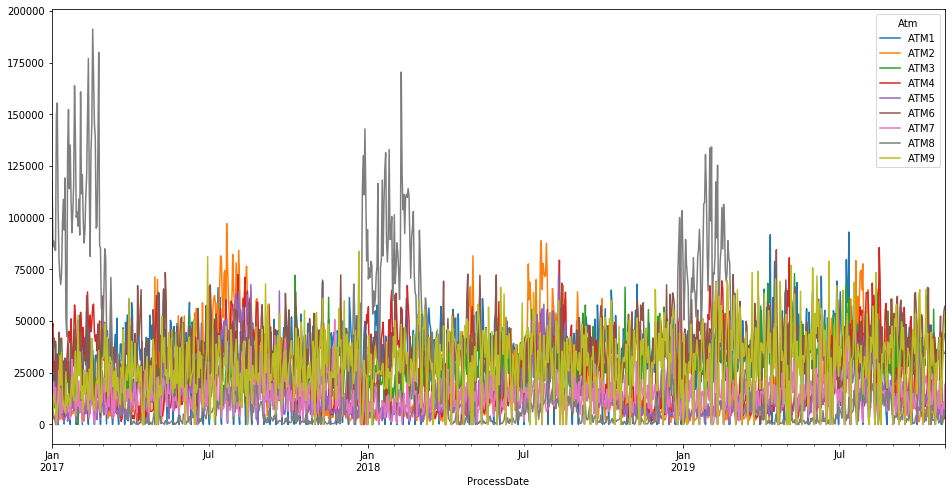

In [8]:
new_df.plot(figsize=(16, 8));

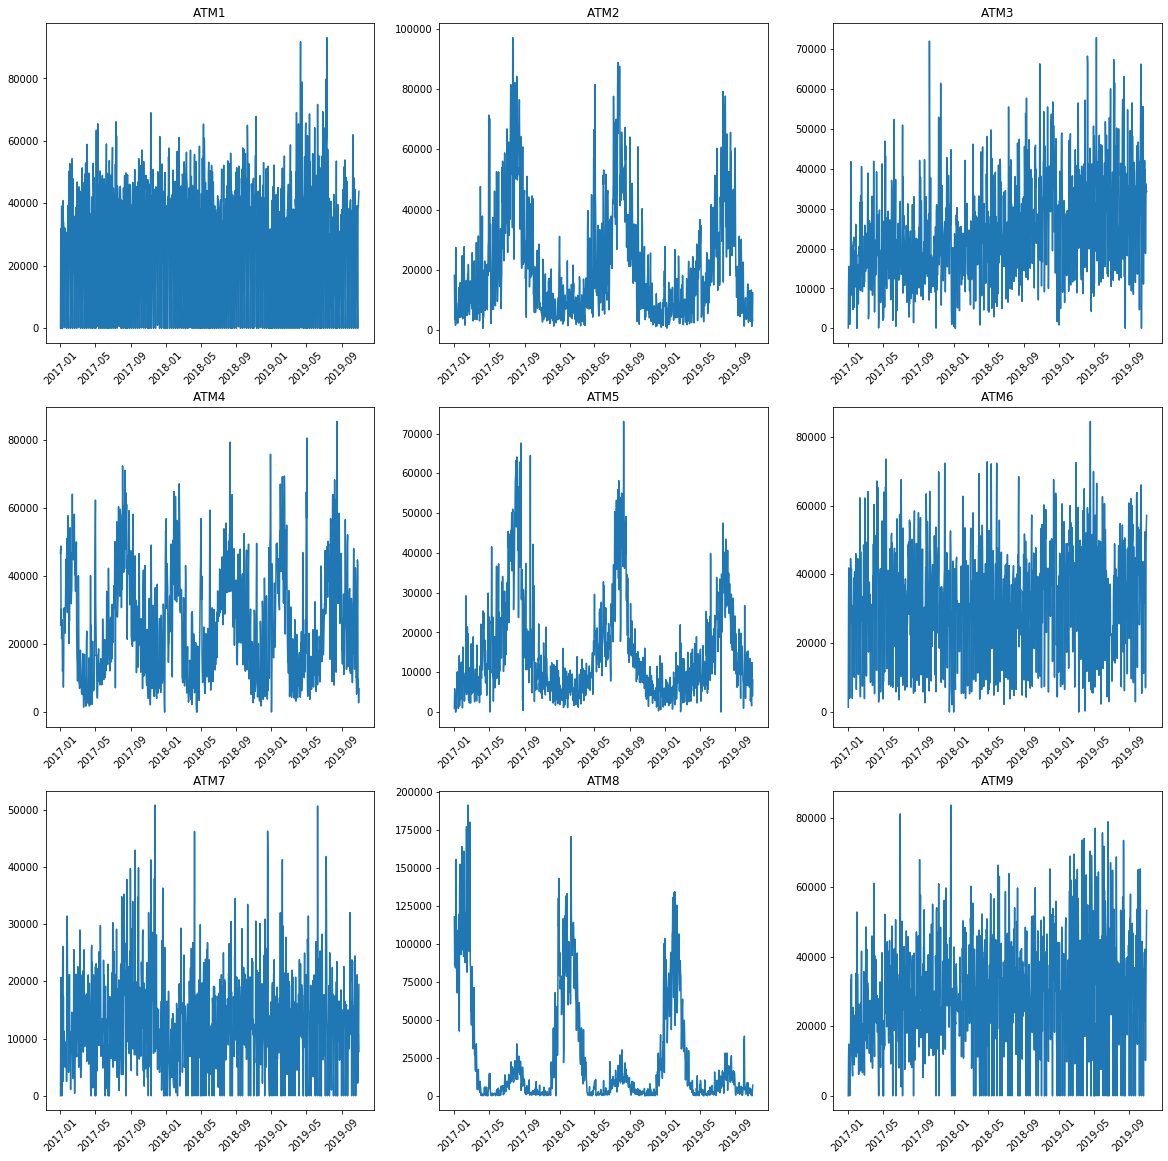

In [9]:
fig = plt.figure(figsize=(20,20))

for i in range(len(new_df.columns)):
    plt.subplot(3, 3, i+1)
    plt.plot(new_df.iloc[:, i])
    plt.xticks(rotation=45)
    plt.title(new_df.columns[i])

Z powyższych wykresów widać, że w danych nie występuje wyraźny trend, natomiast niektóre mają sezonowość (około 1 roku, czyli ok. 360 dni). Tak dla ATM2, ATM4, ATM5 wypłaty rosną w okresie letnim i spadają w okresie zimowym, natomiast wypłaty z ATM8 najbardziej rosną w okresie zimowym i są to wartości znacznie wyższe niż przy innych bankomatach, może to wynikać z lokalizacji. ATM1 (w mniejszej mierze ATM7 i ATM9) ma dużo dni z wartością 0 albo około 0, co może wskazywać na częstą niedostepność bankowamu (np. awaria) czy złą lokalizacje.

Przy prognozowaniu wypłat można użyć kilka strategii: <br>
 1) jeden model dla wszystkich bankomatów (np. na podstawie średniej) <br>
 2) pogrupować bankomaty z podobnymi zachowaniami (np. ATM2, ATM4, ATM5) i wytrenować model dla każdej grupy <br>
 3) wytrenować osobny model dla każdego bankomatu <br>
 
Pierwsza strategia wydaje się być mało dokładna ze wzgłędu na różnorodność danych. Trzecia strategia wydaje się być najbardziej dokładna ponieważ model uczy się na danych dt. tylko jednego bankowamu, wadą natomiast może być wydajność, o ile wytrenowanie 9 modeli nie będzię sprawiać problemu, tak przy tysiącach bankomatów może to potrzbować znacznych zasobów. Druga strategia wydaje sie najbardziej sensowna, ponieważ zakłada trenowanie mniejszej liczby modeli, niż w 3 strategii, natomiast modele te bedą bardziej dokładne niż w strategii nr. 1.   

Ze względu na to, że bankomatów jest 9, przeanalizuje każdy z osobna. Planuje użyć kilka podejść do modelowania, w zależności od bankomatu i czy dane są stacjonarne czy nie. Dla stacjonarnych szeregów czasowych użyje sieci neuronowe lub modelu ARIMA, natomiast dla  niestacjonarnych wygładzanie wykładnicze. Na początku napiszę kilka funkcji do każdego podejścia, którę będę wykorzystywać więcej niż raz. Jako pomiar błędu będę używać RMSE.



### Niezbędne funkcje

In [10]:
#stałe
test_size = 30
n_forecast = 60

In [11]:
def ES_train(data, test_size=30, seasonal_periods=360):
    
    train, test = data.iloc[:-test_size, 0], data.iloc[-test_size:, 0]
    
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit()
    preds = model.forecast(test_size)
    
    print(f'RMSE: {rmse(test, preds)}')
    print(f'Mean: {np.mean(data.iloc[:, 0])}')
    
    test.plot(figsize=(20, 5))
    preds.plot();
    
    
def ES_forecast(data, n_forecast=n_forecast, seasonal_periods=360):
    model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit()
    preds = model.forecast(n_forecast)
    
    data.iloc[:, 0].plot(figsize=(20, 5))
    preds.plot();

In [80]:
def ARIMA_train(data, order=None, test_size=30, seasonal_order=None, enforce_stationarity=False, enforce_invertibility=False):
    """Trenowanie modelu ARIMA na zbiorze treningowym oraz sprawdzenie na danych testowych"""
    train = data.iloc[:-test_size]
    test = data.iloc[-test_size:]

    start = len(train)
    end = len(train) + len(test) - 1

    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility).fit()
    preds = model.predict(start, end).rename('Predykcja')

    print(f"RMSE: {rmse(test.iloc[:,0], preds)}")
    print(f"Mean: {np.mean(data.iloc[:, 0])}")
    test.plot(legend=True, figsize=(20, 5))
    preds.plot(legend=True);


def ARIMA_forecast(data, order, periods=60, seasonal_order=None, enforce_stationarity=False, enforce_invertibility=False):
    """Trenowanie modelu ARIMA na całym zbiorze oraz predykcja na następne 60 dni wraz z wykresem"""
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order, enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_stationarity).fit()
    preds = model.predict(len(data), len(data)+periods).rename('Predykcja')
    
    data.plot(legend=True, figsize=(20, 5))
    preds.plot(legend=True);

In [13]:
def train_rnn(data, test_size=30, n=29, n_features=1):
    """Trenowanie sieci rekurencyjnej na danych treningowych oraz sprawdzanie na danych testowych"""
    
    train = data.iloc[:-test_size]
    test = data.iloc[-test_size:]
    
    scalar = MinMaxScaler()
    train_norm = scalar.fit_transform(train.iloc[:, [0]])
    test_norm = scalar.transform(test.iloc[:, [0]])
    
    train_generator = TimeseriesGenerator(train_norm, train_norm, length=n, batch_size=1)
    test_genetator = TimeseriesGenerator(test_norm, test_norm, length=n, batch_size=1)
    
    model = Sequential()
    model.add(LSTM(250, activation='relu', input_shape=(n, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    model.fit_generator(train_generator, epochs=15, validation_data=test_genetator)
    
    test_preds = []
    first_batch = train_norm[-n:]
    current_batch = first_batch.reshape(1, n, n_features)

    for i in range(len(test)):

        pred = model.predict(current_batch)[0]
        test_preds.append(pred)

        current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

    
    true_test = scalar.inverse_transform(test_preds)
    
    test['Predykcja'] = true_test
    
    print(f"RMSE: {rmse(test.iloc[:, 0], test.iloc[:, 1])}")
    print(f"Mean: {np.mean(data.iloc[:, 0])}")
    
    test.iloc[:, :2].plot()

In [14]:
def rnn_forecast(data, n=29, n_features=1, n_forecast=n_forecast):
    """Trenowanie sieci rekurencyjnej na pełnych danych oraz prognozowanie n okresów do przodu. Zwrada datafame z prognozami"""

    scalar = MinMaxScaler()
    train_norm = scalar.fit_transform(data.iloc[:, [0]])

    train_generator = TimeseriesGenerator(train_norm, train_norm, length=n, batch_size=1)

    model = Sequential()
    model.add(LSTM(250, activation='relu', input_shape=(n, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    model.fit_generator(train_generator, epochs=15)
    
    test_preds = []
    first_batch = train_norm[-n:]
    current_batch = first_batch.reshape(1, n, n_features)

    for i in range(n_forecast):

        pred = model.predict(current_batch)[0]
        test_preds.append(pred)

        current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

    true_test = scalar.inverse_transform(test_preds)
    
    forecast = pd.DataFrame(index=pd.date_range('2019-11-01', periods=n_forecast), columns=['Predykcja'], data=true_test)
    
    data.plot(figsize=(20, 5))
    forecast['Predykcja'].plot();

### ATM 1

In [17]:
atm1 = new_df[['ATM1']]

RMSE: 8346.780247787963
Mean: 30293.346228239847


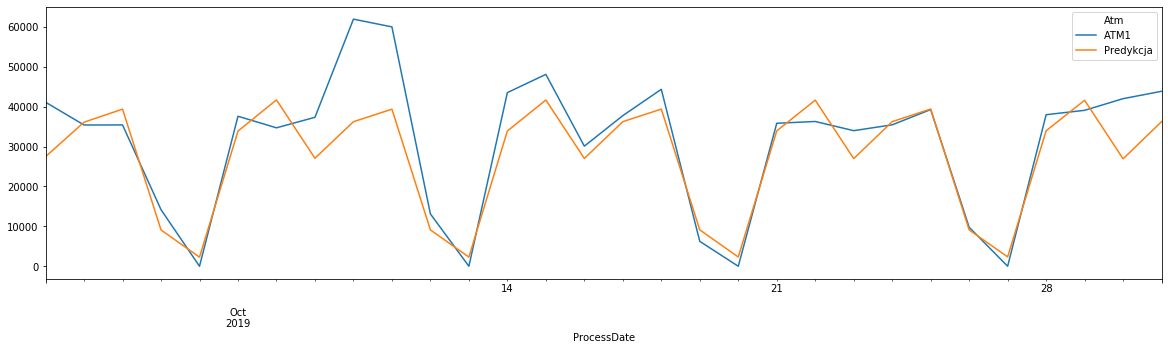

In [60]:
#trenowanie i sprawdzanie na danych testowych
ARIMA_train(atm1, order=(5, 1, 5))

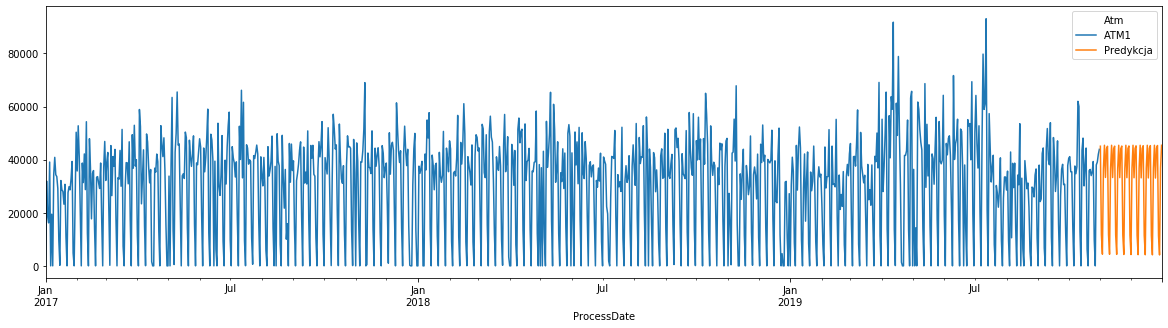

In [61]:
#Predykcja
ARIMA_forecast(atm1, order=(5, 1, 5))

### ATM 2

In [20]:
atm2 = new_df[['ATM2']]

RMSE: 6865.831179035109
Mean: 21134.50676982592


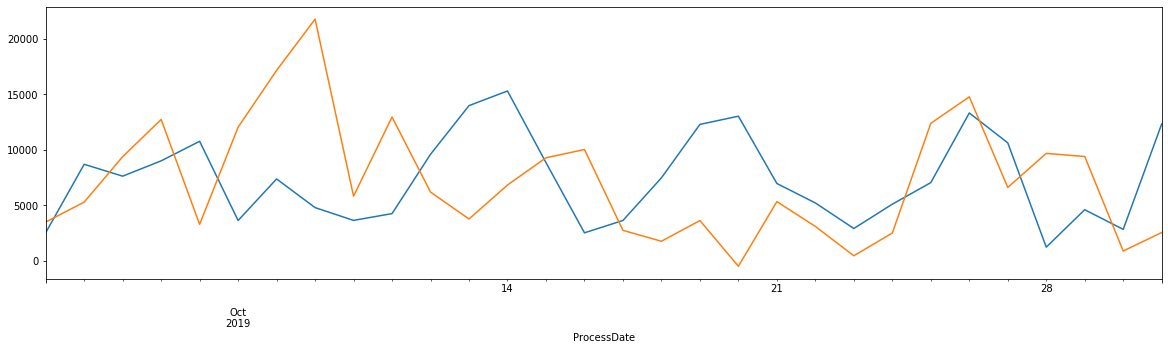

In [21]:
#trenowanie i sprawdzanie na danych testowych
ES_train(atm2)

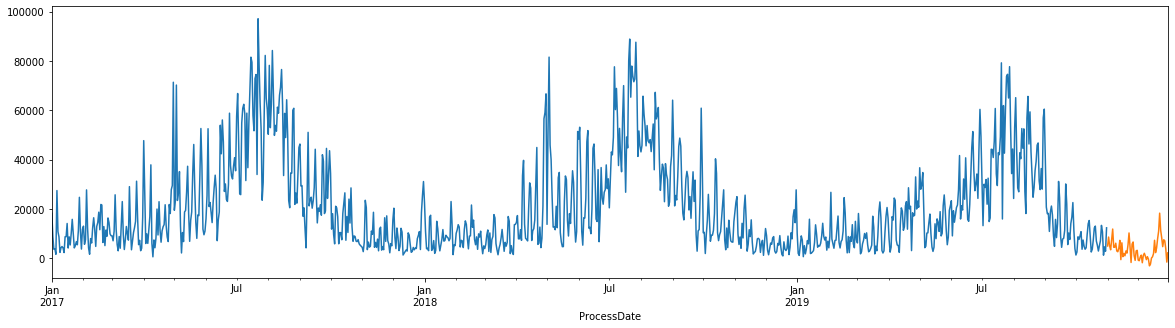

In [22]:
#Predykcja 
ES_forecast(atm2)

### ATM 3

In [23]:
atm3 = new_df[['ATM3']]

RMSE: 11703.535775295482
Mean: 25271.411992263056


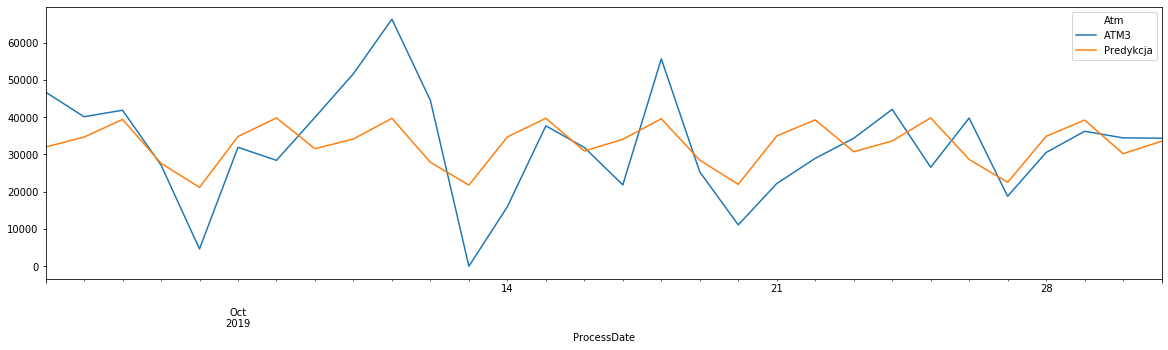

In [173]:
#trenowanie i sprawdzanie na danych testowych
ARIMA_train(atm3, order=(5, 1, 7), enforce_stationarity=True)

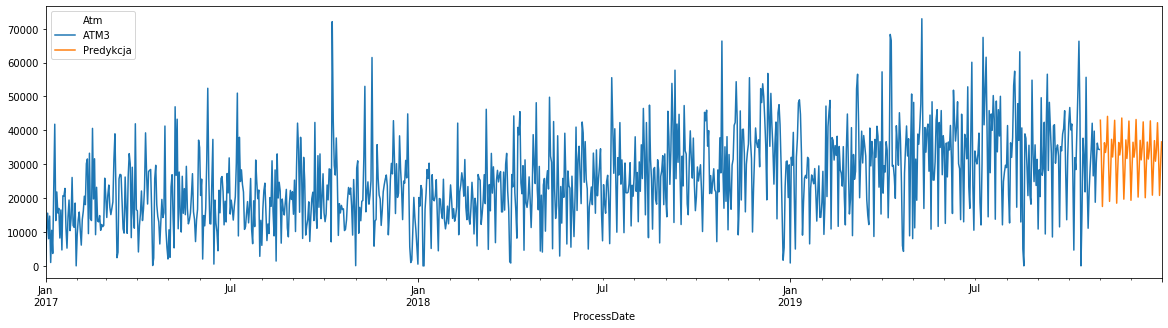

In [172]:
#Predykcja
ARIMA_forecast(atm3, order=(5, 1, 7), enforce_stationarity=True)

### ATM 4

In [26]:
atm4 = new_df[['ATM4']]

Epoch 1/15
975/975 [==============================] - 28s 29ms/step - loss: 0.0247 - val_loss: 0.0164
Epoch 2/15
975/975 [==============================] - 28s 29ms/step - loss: 0.0202 - val_loss: 0.0085
Epoch 3/15
975/975 [==============================] - 27s 28ms/step - loss: 0.0181 - val_loss: 0.0050
Epoch 4/15
975/975 [==============================] - 27s 28ms/step - loss: 0.0170 - val_loss: 0.0079
Epoch 5/15
975/975 [==============================] - 28s 28ms/step - loss: 0.0165 - val_loss: 5.2514e-06
Epoch 6/15
975/975 [==============================] - 27s 27ms/step - loss: 0.0157 - val_loss: 4.0386e-04
Epoch 7/15
975/975 [==============================] - 27s 27ms/step - loss: 0.0145 - val_loss: 0.0016
Epoch 8/15
975/975 [==============================] - 27s 27ms/step - loss: 0.0142 - val_loss: 0.0013
Epoch 9/15
975/975 [==============================] - 28s 29ms/step - loss: 0.0138 - val_loss: 0.0019
Epoch 10/15
975/975 [==============================] - 29s 30ms/step - los

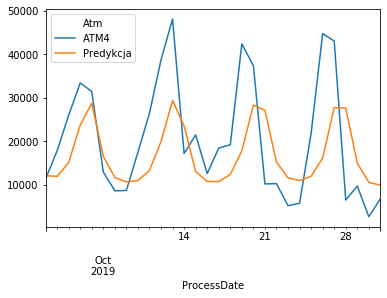

In [27]:
#trenowanie i sprawdzanie na danych testowych
train_rnn(atm4)

Epoch 1/15
1005/1005 [==============================] - 28s 28ms/step - loss: 0.0237
Epoch 2/15
1005/1005 [==============================] - 27s 27ms/step - loss: 0.0204
Epoch 3/15
1005/1005 [==============================] - 28s 27ms/step - loss: 0.0177
Epoch 4/15
1005/1005 [==============================] - 28s 28ms/step - loss: 0.0169
Epoch 5/15
1005/1005 [==============================] - 30s 29ms/step - loss: 0.0159
Epoch 6/15
1005/1005 [==============================] - 29s 29ms/step - loss: 0.0145
Epoch 7/15
1005/1005 [==============================] - 28s 28ms/step - loss: 0.0133
Epoch 8/15
1005/1005 [==============================] - 28s 27ms/step - loss: 0.0133
Epoch 9/15
1005/1005 [==============================] - 28s 28ms/step - loss: 0.0127
Epoch 10/15
1005/1005 [==============================] - 29s 29ms/step - loss: 0.0128
Epoch 11/15
1005/1005 [==============================] - 29s 29ms/step - loss: 0.0130
Epoch 12/15
1005/1005 [==============================] - 28s 28

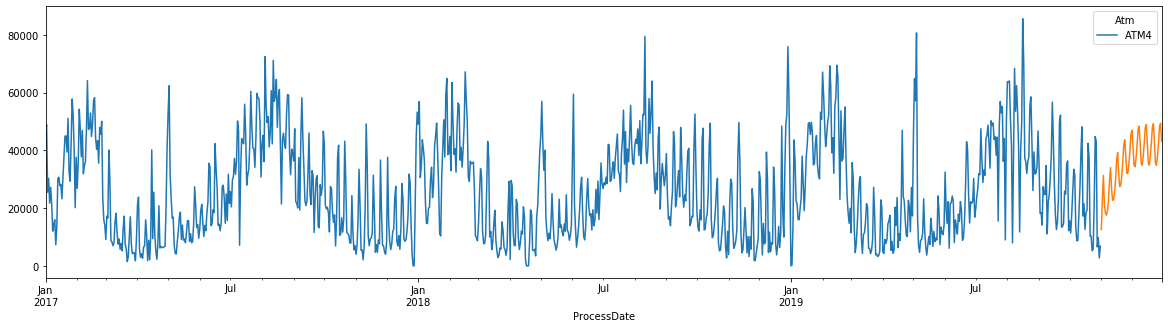

In [28]:
#Predykcja
rnn_forecast(atm4)

### ATM 5

In [29]:
atm5 = new_df[['ATM5']]

RMSE: 6571.294011604339
Mean: 14954.883945841393


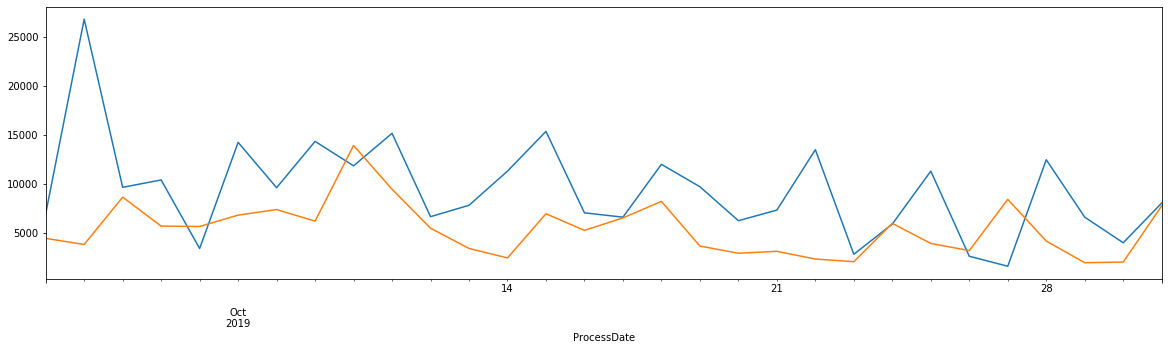

In [30]:
#trenowanie i sprawdzanie na danych testowych
ES_train(atm5)

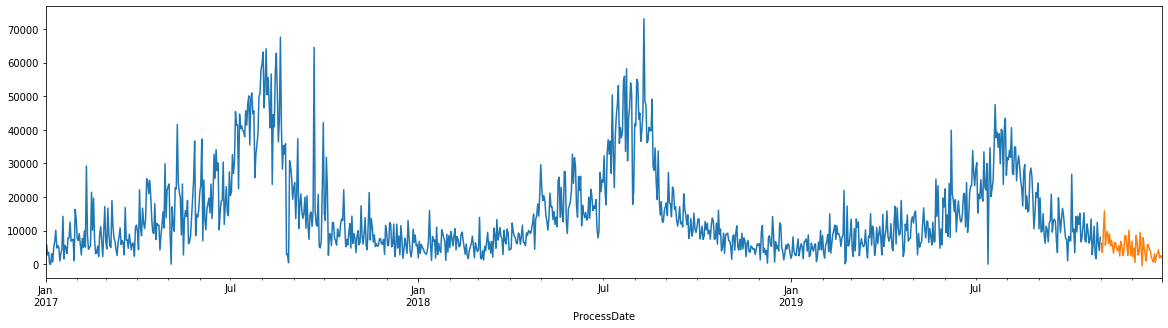

In [31]:
#Predykcja 
ES_forecast(atm5)

### ATM 6

In [32]:
atm6 = new_df[['ATM6']]

RMSE: 12720.013470706424
Mean: 34208.056092843326


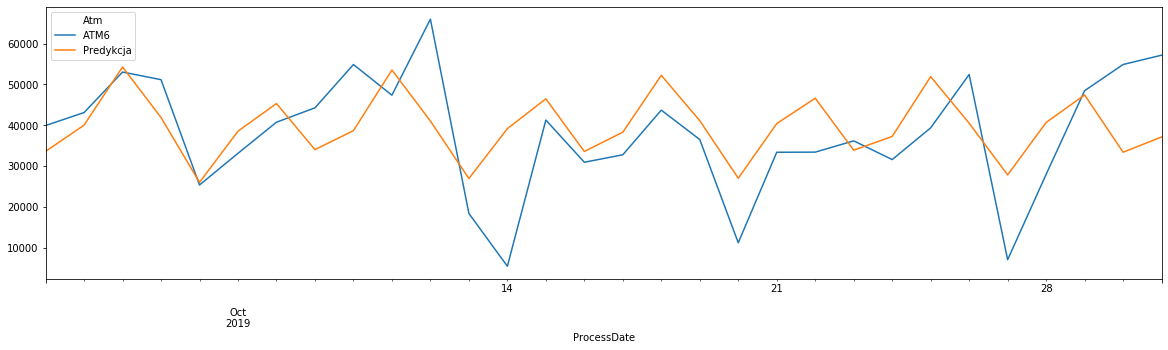

In [81]:
#trenowanie i sprawdzanie na danych testowych
ARIMA_train(atm6, order=(5, 1, 6), enforce_stationarity=True)

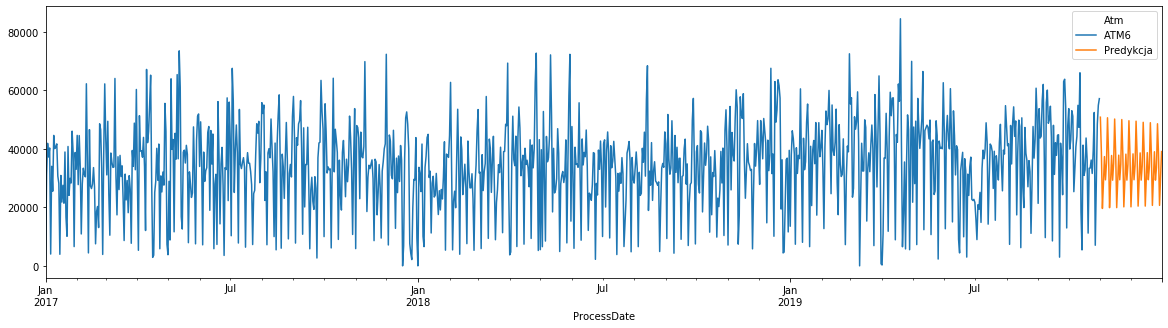

In [93]:
#Predykcja 
ARIMA_forecast(atm6, order=(5, 1, 6), enforce_stationarity=True)

### ATM 7

In [124]:
atm7 = new_df[['ATM7']]

RMSE: 5817.535362758986
Mean: 12958.791102514508


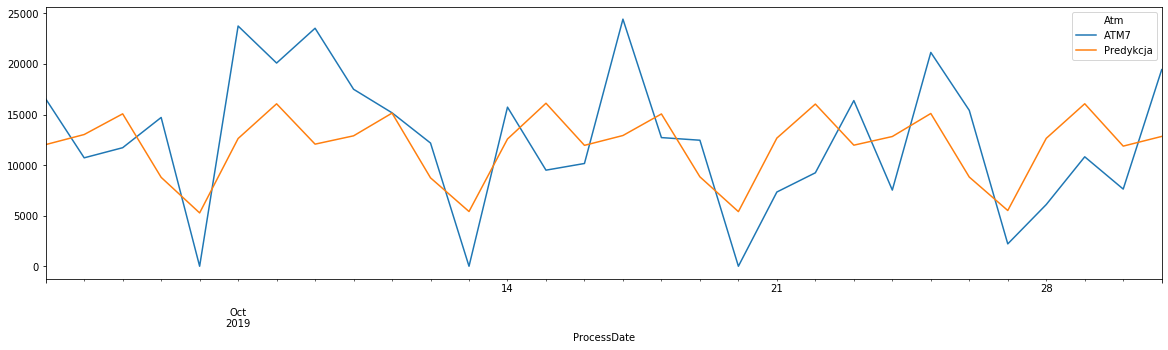

In [155]:
#trenowanie i sprawdzanie na danych testowych
ARIMA_train(atm7, order=(5, 1, 6), enforce_stationarity=True)

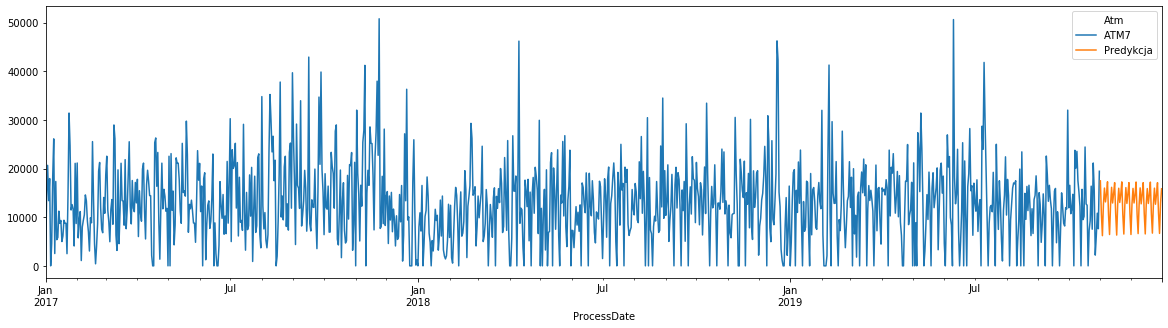

In [156]:
#Predykcja 
ARIMA_forecast(atm7, order=(5, 1, 7), enforce_stationarity=True)

### ATM 8

In [38]:
atm8 = new_df[['ATM8']]

RMSE: 12109.036663964382
Mean: 24330.996131528045


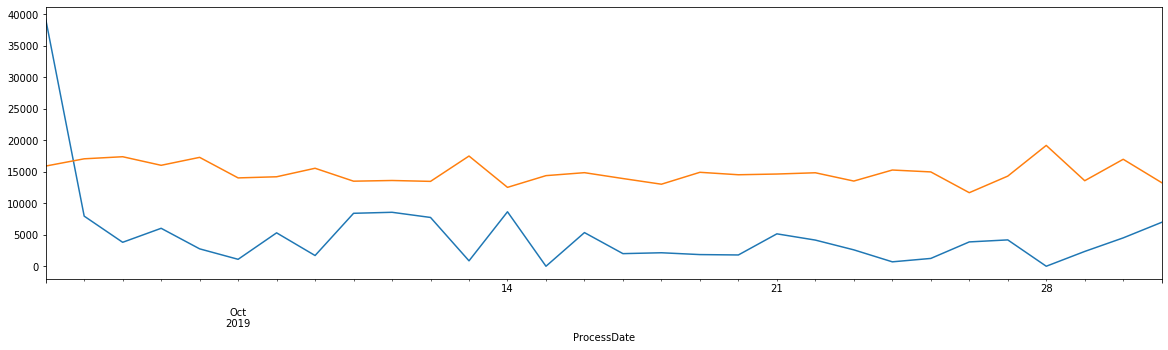

In [39]:
#trenowanie i sprawdzanie na danych testowych
ES_train(atm8)

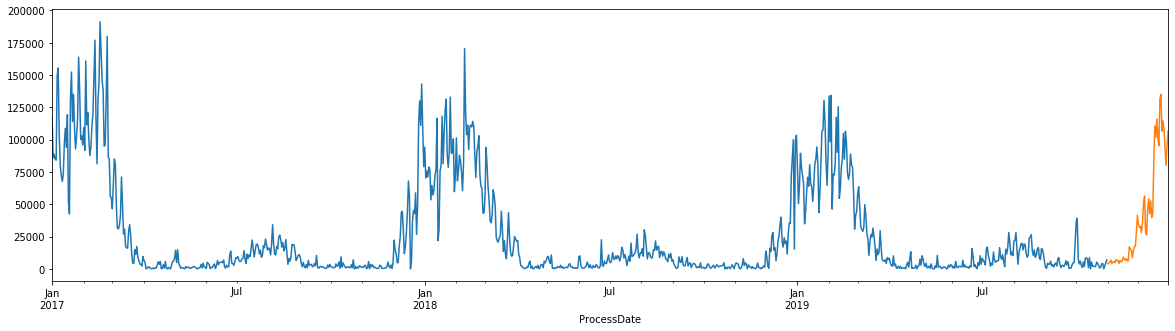

In [40]:
#Predykcja 
ES_forecast(atm8)

### ATM 9

In [41]:
atm9 = new_df[['ATM9']]

Epoch 1/15
975/975 [==============================] - 28s 29ms/step - loss: 0.0381 - val_loss: 0.0926
Epoch 2/15
975/975 [==============================] - 28s 29ms/step - loss: 0.0368 - val_loss: 0.0348
Epoch 3/15
975/975 [==============================] - 28s 28ms/step - loss: 0.0358 - val_loss: 0.0555
Epoch 4/15
975/975 [==============================] - 33s 34ms/step - loss: 0.0355 - val_loss: 0.0862
Epoch 5/15
975/975 [==============================] - 34s 34ms/step - loss: 0.0347 - val_loss: 0.0560
Epoch 6/15
975/975 [==============================] - 30s 31ms/step - loss: 0.0335 - val_loss: 0.0280
Epoch 7/15
975/975 [==============================] - 31s 32ms/step - loss: 0.0313 - val_loss: 0.0312
Epoch 8/15
975/975 [==============================] - 29s 30ms/step - loss: 0.0308 - val_loss: 0.0411
Epoch 9/15
975/975 [==============================] - 28s 29ms/step - loss: 0.0299 - val_loss: 0.0220
Epoch 10/15
975/975 [==============================] - 28s 29ms/step - loss: 0.031

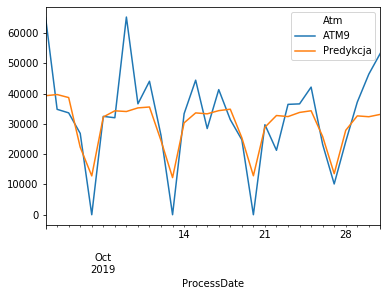

In [42]:
#trenowanie i sprawdzanie na danych testowych
train_rnn(atm9)

Epoch 1/15
1005/1005 [==============================] - 30s 30ms/step - loss: 0.0395
Epoch 2/15
1005/1005 [==============================] - 29s 28ms/step - loss: 0.0367
Epoch 3/15
1005/1005 [==============================] - 29s 28ms/step - loss: 0.0364
Epoch 4/15
1005/1005 [==============================] - 28s 28ms/step - loss: 0.0357
Epoch 5/15
1005/1005 [==============================] - 29s 29ms/step - loss: 0.0353
Epoch 6/15
1005/1005 [==============================] - 29s 28ms/step - loss: 0.0341
Epoch 7/15
1005/1005 [==============================] - 29s 28ms/step - loss: 0.0325
Epoch 8/15
1005/1005 [==============================] - 29s 29ms/step - loss: 0.0310
Epoch 9/15
1005/1005 [==============================] - 29s 29ms/step - loss: 0.0300
Epoch 10/15
1005/1005 [==============================] - 30s 29ms/step - loss: 0.0292
Epoch 11/15
1005/1005 [==============================] - 29s 29ms/step - loss: 0.0275
Epoch 12/15
1005/1005 [==============================] - 30s 29

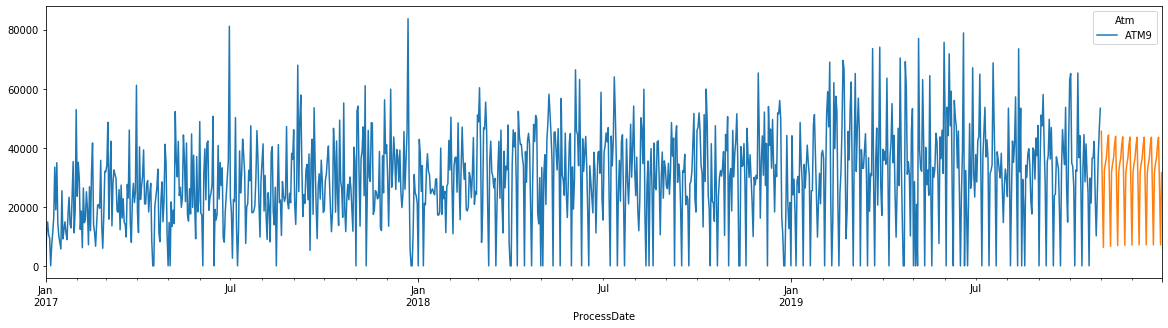

In [43]:
#Predykcja 
rnn_forecast(atm9)

## Zadanie 2

2. Bankomaty czasem ulegają awariom lub są niedostępne dla klientów. Takie zdarzenia skutkują obniżeniem lub całkowitym brakiem wypłat i mogą wpływać na zaniżenie wartości prognozowanych przez modele. Opisz w jaki sposób poradziłbyś sobie z tym problemem. (Opis)



Zależy od: 
* czy to są płanowane wylączenie bankomatu
* czy awaria

Jeśli planowane, to należy należy rozważyć wprowadzenie dodatkowych cech, np. ilość godzin kiedy bankomat nie będzie dostępny (np. ile będą trwać pracę remontowe). Uwgzlędniająć te dane bęzie można zobaczyć jak te wartości wpływały na ilość wypłacanych pieniędzy tego dnia i uwzględnić zapłanowane wyłączenia bankomatu przy prognozie. 

Natomist w przypadku awarii można dokonać analizy jak często takie awarię się zdarząja i jak często ten psuje się konkretnie ten bankowam, kiedy ostatni raz miała miejsce taka awaria dla tego bankomatu, kiedy ostatni raz była naprawa, czy awarię zależą od obłożenia i od czasu używania. Wszystkie te czynniki potencjalnie można wykorzystać w analizie i prognozowaniu.

Należy też zwrócić uwagę i sprawdzić, jak wylączony bankomat wpłynał na kwoty wypłacane w innych bankomaty w pobliżu.